In [11]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
from os.path import join, abspath
from os import pardir, curdir, mkdir
import sys
import healpy as hp
from scipy import interpolate

In [2]:
root_data_dir = abspath(join(pardir, "Data"))
comp_dir = join(root_data_dir, "Completeness")

In [3]:
name = "Effective-Volume"
data_dir = join(root_data_dir, name)
try:
  mkdir(data_dir)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [39]:
comp_A = vaex.open(join(comp_dir, "comp-A-2.hdf5"))
comp_F = vaex.open(join(comp_dir, "comp-F-2.hdf5"))
comp_G = vaex.open(join(comp_dir, "comp-G-2.hdf5"))
comp_G

#,DM,comp
0,-2.0,0.0
1,-1.914572864321608,0.0
2,-1.829145728643216,0.0
3,-1.7437185929648242,0.0
4,-1.6582914572864322,0.0
...,...,...
195,14.658291457286431,0.0
196,14.743718592964822,0.0
197,14.829145728643216,0.0
198,14.914572864321606,0.0


In [40]:
# add distance column in kpc
distance = np.power(10, (comp_A.DM.to_numpy()+5)/5)
comp_A["distance"] = distance
distance = np.power(10, (comp_F.DM.to_numpy()+5)/5)
comp_F["distance"] = distance
distance = np.power(10, (comp_G.DM.to_numpy()+5)/5)
comp_G["distance"] = distance
comp_G

#,DM,comp,distance
0,-2.0,0.0,3.9810717055349722
1,-1.914572864321608,0.0,4.140811179107124
2,-1.829145728643216,0.0,4.306960157783548
3,-1.7437185929648242,0.0,4.479775821300495
4,-1.6582914572864322,0.0,4.659525668664681
...,...,...,...
195,14.658291457286431,0.0,8543.941998877026
196,14.743718592964822,0.0,8886.765464034419
197,14.829145728643216,0.0,9243.344632154005
198,14.914572864321606,0.0,9614.231447262957


In [41]:
comp = [comp_A, comp_F, comp_G]
comp

[#    DM                   comp    distance
 0    0.0                  0.0     10.0
 1    0.08542713567839195  0.0     10.401247416242368
 2    0.1708542713567839   0.0     10.818594781388855
 3    0.2562814070351759   0.0     11.2526881017294
 4    0.3417085427135678   0.0     11.704199304389416
 ...  ...                  ...     ...
 195  16.65829145728643    0.0     21461.411978584016
 196  16.74371859296482    0.0     22322.545589116013
 197  16.829145728643216   0.0     23218.23196327455
 198  16.914572864321606   0.0     24149.8575217725
 199  17.0                 0.0     25118.864315095823,
 #    DM                   comp    distance
 0    -1.0                 0.0     6.309573444801933
 1    -0.9095477386934674  0.0     6.577948246675436
 2    -0.8190954773869347  0.0     6.857738247200756
 3    -0.728643216080402   0.0     7.149428986597581
 4    -0.6381909547738693  0.0     7.453526657315321
 ...  ...                  ...     ...
 195  16.63819095477387    0.0     21263.668399

In [42]:
# create function that gives completeness given distance
# 0 = A, 1 = F, 2 = G
comp_interp = []
for j in range(3):
  comp_i = comp[j]
  f = interpolate.interp1d(comp_i["distance"].to_numpy(), comp_i["comp"].to_numpy(), kind="cubic", fill_value=0, bounds_error=False)
  comp_interp.append(f)
comp_interp

In [43]:
# GLAT, GLON in rad, spec=0 for A, 1 for F, and 2 for G, distance in kpc
def completeness(distance, spec):
  return comp_interp[spec](distance)

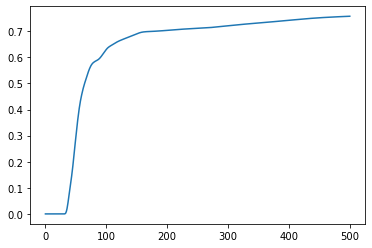

In [77]:
d = np.linspace(0, 500, 1000)
plt.plot(d, completeness(d, 0), label="A")

In [68]:
Z = 200
R = 150

In [78]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 102) #edges
er = np.linspace(0, R, 102)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2

In [91]:
# volume of rings
# Vol = base*heigh = pi*(r1^2-r0^2)*dz
# for A for 1st index, F 2nd, G 3rd
vol = np.empty((3, len(z), len(r)))
real_vol = np.empty((len(z), len(r)))
dz = ez[1]-ez[0]

for i, zz in enumerate(z):
  # print(i, zz, end=" | ")
  for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
    v = np.pi*(r_out**2-r_in**2)*dz
    distance =np.sqrt(rr**2+zz**2)
    c = np.empty(3)
    for k in range(3):
      c[k] = completeness(distance, k)
      vol[k, i, j] = v*c[k]
    real_vol[i, j] = v

In [92]:
vz = [np.sum(vol[k], axis=1) for k in range(3)]
real_vz = np.sum(real_vol, axis=1)

In [93]:
compz = [vz[i]/real_vz for i in range(3)]

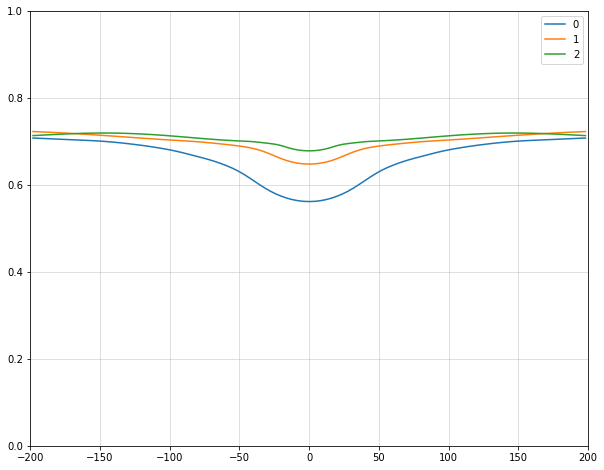

In [94]:
plt.figure(figsize=(10,8))
for i in range(3):
  plt.plot(z, compz[i], label=i)
plt.ylim(0,1)
plt.xlim(-200, 200)
plt.grid(alpha=0.5)
plt.legend()

In [95]:
df = vaex.from_arrays(z=z, A=compz[0], F=compz[1], G=compz[2])
df

#,z,A,F,G
0,-198.01980198019803,0.7077069188540818,0.7226139139976796,0.7133188364188764
1,-194.05940594059405,0.7071727396188972,0.7220997362669332,0.713952250123703
2,-190.0990099009901,0.7066207567176711,0.7215500645948397,0.7145994661562005
3,-186.13861386138615,0.706056327503454,0.7209633904436771,0.71524911760719
4,-182.17821782178217,0.7054861011548819,0.7203392493978681,0.715889595155641
...,...,...,...,...
96,182.17821782178217,0.7054861011548819,0.7203392493978681,0.715889595155641
97,186.13861386138612,0.706056327503454,0.7209633904436771,0.71524911760719
98,190.0990099009901,0.7066207567176711,0.7215500645948397,0.7145994661562005
99,194.05940594059408,0.7071727396188972,0.7220997362669332,0.7139522501237029


In [96]:
df.export(join(data_dir, "comp-new.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
 